**Question**

A current of magnitude I flows in the circular conductor wire shown in the figure (red curve). By how much does the magnitude of the magnetic field $B$ change at the center of the circle (at point $P$) if the unstretchable wire is deformed as shown in the figure (blue curve) while remaining in the plane of the original circle? We expect a numerical result accurate to three decimal places, with a detailed description of the calculation procedure.

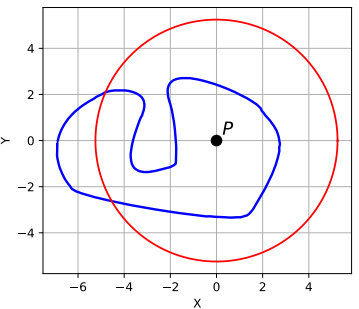

In [28]:
from IPython.display import Image
Image(filename='figures/image_17.png') 

**Answers**

The magnetic field produced by a current-carrying wire on a point can be computed using Biot-Savart equation
\begin{equation*}
\vec{B} = \frac{\mu_0 I}{4\pi}\int \frac{d\vec{l} \times \vec{r}}{|\vec{r}|^3}
\end{equation*}
where $d\vec{l}$ is the vector representing the direction of the current at the wire segment, while $\vec{r}$ is the vector connecting the segment into the point.

**Magnetic field in the center of circular loop**

For a circular loop with constant current, $d\vec{l} \times \vec{r} = d\phi ~R^2~\hat{z}$ in the centre of the loop, with $\hat{z}$ the direction perpendicular to the loop plane and $R$ the radius of the loop, resulting in
\begin{equation*}
\vec{B} = B_z~\hat{z} = \frac{\mu_0 I}{2R}~\hat{z}
\end{equation*}

**Magnetic field of known points**

In this question, we are dealing with an irregular loop. The best we could have are the data points of this loop. If we denote each sequential points as $x_i, y_i$, we could approximate $d\vec{l}$ and $\vec{r}$ with respect to the centre of the plane as

\begin{equation*}
d\vec{l}_i = \frac{1}{2}(x_{i+1} - x_{i-1}, y_{i+1} - y_{i-1}) ~~~~~\vec{r}_i = (x_i, y_i)\implies d\vec{l}_i \times r_i = \frac{1}{2}\left[(x_{i+1} - x_{i-1})y_i - (y_{i+1} - y_{i-1})x_i\right]
\end{equation*}

Leading to
\begin{equation*}
B^{\text{irr}}_z = \frac{\mu_0 I}{4\pi}\sum_{i}\frac{1}{2}\frac{(x_{i+1} - x_{i-1})y_i - (y_{i+1} - y_{i-1})x_i}{(x_i^2 + y_i^2)^{3/2}} = \frac{\mu_0 I}{4\pi}\mathcal{B}^{\text{irr}}
\end{equation*}

Our task is to somehow obtain these data points as accurately as possible and compute the magnetic field ratio, which is either $\mathcal{B}^{\text{irr}}/\mathcal{B}^{\text{circ}}$ or $\mathcal{B}^{\text{irr}}/(2\pi/R)$, where $\mathcal{B}^{\text{circ}}$ is computed from the circular loop data points, and should converge to $2\pi R$.

**Numerical recipe**

Our strategy is to extract the data points in ```python``` using ```cv2``` library, which specialise in analysing pixels in picture.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('figures/image_17.png')

Here, we will convert the image into HSV colour scheme, and then select the pixels for the circular and irregular loop by picking blue and red colour range, respectively.

In [30]:
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Blue colour range
lower = np.array([10, 10, 10])
upper = np.array([255, 255, 255])

mask_irr = cv2.inRange(hsv, lower, upper)

# Red colour range (use two masks and then combine them)
lower1 = np.array([0, 100, 100])
upper1 = np.array([10, 255, 255])
lower2 = np.array([170, 100, 100])
upper2 = np.array([180, 255, 255])
mask1 = cv2.inRange(hsv, lower1, upper1)
mask2 = cv2.inRange(hsv, lower2, upper2)
mask_cir = mask1 | mask2

Now we extract the contour, which will provide us with $\{x, y\}$ data points for both loops.

In [31]:
contours_irr, hierarchy_irr = cv2.findContours(image=mask_irr, mode=cv2.RETR_TREE, 
                                               method=cv2.CHAIN_APPROX_NONE)
contours_cir, hierarchy_cir = cv2.findContours(image=mask_cir, mode=cv2.RETR_TREE, 
                                               method=cv2.CHAIN_APPROX_NONE)

irloop = contours_irr[0].squeeze()
circle = contours_cir[0].squeeze()

We can try plotting these contours to see whether we have extracted the correct loops or not.

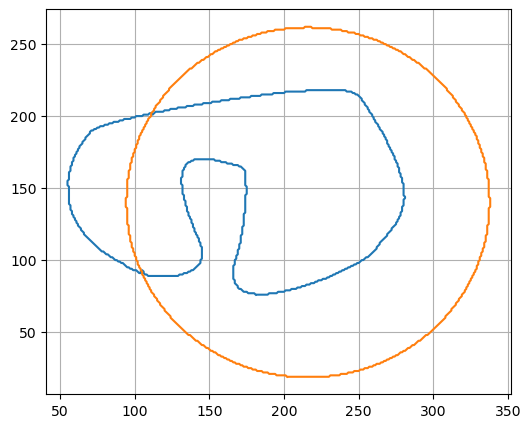

In [32]:
fig, ax = plt.subplots(figsize = (6, 5))
ax.plot(irloop[:,0], irloop[:,1])
ax.plot(circle[:,0], circle[:,1])
plt.grid('True')

Seems like they are upside down! We are also not sure about the scale nor the position of these points. To do that, we need to process them further. 

One good idea is to find the maximum and minimum point in both direction of the circular loop, and substract both loops using these points.

In [33]:
mid_x = (max(circle[:, 0]) + min(circle[:, 0])) / 2
mid_y = (max(circle[:, 1]) + min(circle[:, 1])) / 2

circle[:, 0] = circle[:, 0] - mid_x
circle[:, 1] = circle[:, 1] - mid_y
irloop[:, 0] = irloop[:, 0] - mid_x
irloop[:, 1] = irloop[:, 1] - mid_y

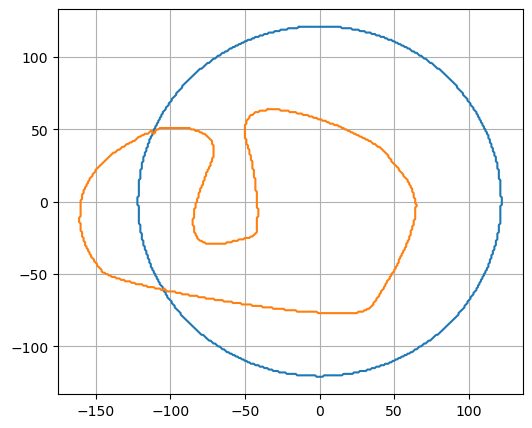

In [34]:
fig, ax = plt.subplots(figsize = (6, 5))
ax.plot(circle[:,0], -circle[:,1])
ax.plot(irloop[:,0], -irloop[:,1])
plt.grid('True')

Now these points looks better. Next, we can shrink them such that the circular loop is a unit circle (Remember, we only need to find the ratio between magnetic field, not each value of magnetic field!).

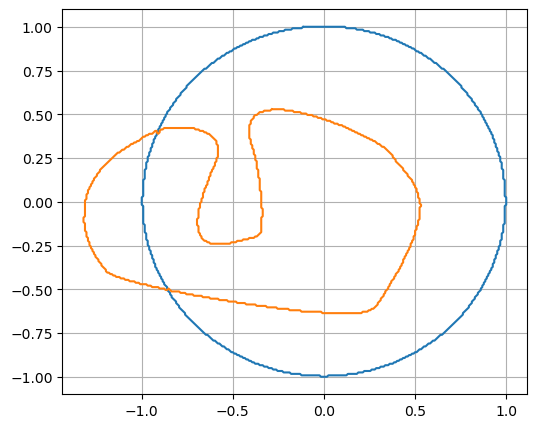

In [35]:
scale_x = 0.5 * (max(circle[:, 0]) - min(circle[:, 0]))
scale_y = 0.5 * (max(circle[:, 1]) - min(circle[:, 1]))

fig, ax = plt.subplots(figsize = (6, 5))
ax.plot(circle[:,0] / scale_x, -circle[:,1] / scale_y)
ax.plot(irloop[:,0] / scale_x, -irloop[:,1] / scale_y)
plt.grid('True')

Now we will include those scales while computing the reduced magnetic field $\mathcal{B}$.

In [36]:
def func(x, y):
    cross = y*(np.roll(x,1)-np.roll(x,-1)) - x*(np.roll(y,1)-np.roll(y,-1))
    radii = x * x + y * y
    return 0.5*(cross / (radii**(3/2))).sum()

res_circle = func(circle[:, 0]/scale_x, -circle[:, 1]/scale_y)
res_irloop = func(irloop[:, 0]/scale_x, -irloop[:, 1]/scale_y)
res_analyt = 2 * np.pi

print(f"analytic circle = {res_analyt:.4f}") 
print(f"numeric circle = {res_circle:.4f}") 
print(f"numeric irregular = {res_irloop:.4f}")

analytic circle = 6.2832
numeric circle = 6.2980
numeric irregular = 11.6506


In [37]:
print(f'numeric/analytic= {res_circle/res_analyt}')
print(f'irregular/circle= {res_irloop/res_circle}')

numeric/analytic= 1.0023650917638012
irregular/circle= 1.8498691301277388


As the numeric and analytic result for the circular loop agrees to third decimals, we could reasonably conclude that also the case for our irregular over circular loop result. In conclusion, we find that the magnetic field change by around $\boxed{1.850}$